#### Problem 7:  Ideal gas, gran canonical ensembl eusing Metropolis–Hastings Monte Carlo 

#### c) model particle number fluctuations

- Use **reduced fugacity** $\zeta = 10$
- Run the simulation for $10^6$ Monte Carlo (MC) steps
- Start with $N_0 = 0$
- The only variable is the **particle number** $N$ (no need for positions or momenta)

Monte Carlo Moves:
At each step, randomly choose between:
- **Insertion**: Propose $N \rightarrow N+1$  
  Acceptance probability:
  
  $A_{\text{ins}} = \min\left(1, \frac{\zeta}{N + 1}\right)$
  
- **Deletion**: Propose $N \rightarrow N-1$, only if $N > 0$  
  Acceptance probability:
  
  $A_{\text{del}} = \min\left(1, \frac{N}{\zeta}\right)$
  

Post-Processing:
- Record particle number $ N_k$ at each step
- Compute and report:
  - **Mean** $\langle N \rangle$
  - **Variance** $\langle (\delta N)^2 \rangle$
- Plot:
  - The **normalized histogram** of sampled $N$
  - Compare with the **theoretical Poisson distribution**:
    
    $p^{\text{eq}}(N) = \frac{\zeta^N}{N!} e^{-\zeta}$
    



Matplotlib created a temporary config/cache directory at /tmp/matplotlib-d5yl87pn because the default path (/home/mi/marcelli/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Simulated ⟨N⟩ = 10.000, Variance = 9.998, Expected = 10


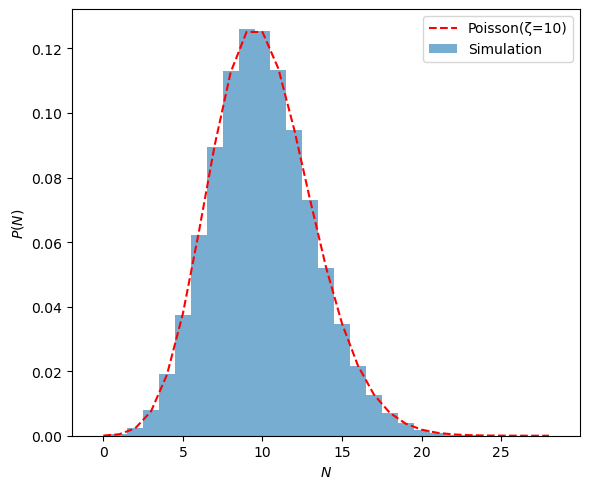

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Parameters
zeta = 10
n_steps = 10**6
N = 0
N_values = []

# Simulation
for _ in range(n_steps):
    if np.random.rand() < 0.5:
        # Attempt insertion
        acc = min(1, zeta / (N + 1))
        if np.random.rand() < acc:
            N += 1
    else:
        # Attempt deletion
        if N > 0:
            acc = min(1, N / zeta)
            if np.random.rand() < acc:
                N -= 1
    N_values.append(N)

# Convert to array
N_values = np.array(N_values)

# Compute statistics
mean_N = np.mean(N_values)
var_N = np.var(N_values)
print(f"Simulated ⟨N⟩ = {mean_N:.3f}, Variance = {var_N:.3f}, Expected = {zeta}")

# Histogram and theoretical Poisson
bins = np.arange(0, np.max(N_values) + 2) - 0.5
hist, edges = np.histogram(N_values, bins=bins, density=True)
centers = 0.5 * (edges[:-1] + edges[1:])
poisson_theory = poisson.pmf(np.arange(len(centers)), mu=zeta)

# Plot
plt.figure(figsize=(6, 5))
plt.bar(centers, hist, width=1, label='Simulation', alpha=0.6)
plt.plot(np.arange(len(poisson_theory)), poisson_theory, 'r--', label='Poisson(ζ=10)')
plt.xlabel('$N$')
plt.ylabel('$P(N)$')
plt.legend()
plt.tight_layout()
plt.show()


#### d) Multi-particle moves

Extend the Metropolis–Hastings scheme to allow insertion and deletion of **multiple particles** per move, i.e., $m \in \{1, 2, \dots, M\}$, and study how this affects the correctness and efficiency of sampling from the Poisson distribution.

Modified Algorithm:
- At each Monte Carlo step:
  - Choose a random integer $m$ from $\{1, 2, ..., M\}$
  - With equal probability, propose:
    - **Insertion**: $N \rightarrow N + m$
    - **Deletion**: $N \rightarrow N - m$ (only if $N \geq m$)

Modified Acceptance Probabilities:

- Insertion of $m$ particles:
  
  $A_{\text{ins}}(m) = \min\left(1, \frac{\zeta^m}{\prod_{i=1}^{m}(N+i)}\right)$
  

- Deletio of $m$ particles:
  
  $A_{\text{del}}(m) = \min\left(1, \frac{\prod_{i=0}^{m-1}(N - i)}{\zeta^m} \right)$
  

These preserve detailed balance under the grand canonical distribution.


In [2]:
from tqdm import tqdm  # Progress bar

def grand_canonical_mc(zeta=10, M=3, n_steps=10**6, seed=None, show_progress=True):
    """
    Grand canonical MC simulation with multi-particle moves and progress tracking.

    Parameters:
    - zeta: float — reduced fugacity
    - M: int — max number of particles inserted/deleted per move
    - n_steps: int — number of MC steps
    - seed: int or None — RNG seed
    - show_progress: bool — show tqdm progress bar

    Returns:
    - results: dict with simulation data
    """
    rng = np.random.default_rng(seed)
    N = 0
    N_values = []

    iterator = tqdm(range(n_steps), desc=f"ζ={zeta}, M={M}", disable=not show_progress)

    for _ in iterator:
        m = rng.integers(1, M + 1)
        if rng.random() < 0.5:
            # Attempt insertion (log-domain)
            log_acc = m * np.log(zeta) - np.sum(np.log(np.arange(N + 1, N + m + 1)))
            acc = min(1, np.exp(log_acc)) if np.isfinite(log_acc) else 0
            if rng.random() < acc:
                N += m
        else:
            # Attempt deletion (log-domain)
            if N >= m:
                log_acc = np.sum(np.log(np.arange(N - m + 1, N + 1))) - m * np.log(zeta)
                acc = min(1, np.exp(log_acc)) if np.isfinite(log_acc) else 0
                if rng.random() < acc:
                    N -= m
        N_values.append(N)

    N_values = np.array(N_values)
    mean = np.mean(N_values)
    variance = np.var(N_values)

    bins = np.arange(0, np.max(N_values) + 2) - 0.5
    hist, edges = np.histogram(N_values, bins=bins, density=True)
    centers = 0.5 * (edges[:-1] + edges[1:])
    poisson_theory = poisson.pmf(np.arange(len(centers)), mu=zeta)

    results = {
        'zeta': zeta,
        'M': M,
        'mean': mean,
        'variance': variance,
        'N_values': N_values,
        'histogram': hist,
        'centers': centers,
        'poisson_theory': poisson_theory
    }

    return results

def plot_histograms(results_dict, title=None):
    """
    Plot multiple MC histograms and Poisson distributions on the same plot.

    Parameters:
    - results_dict: dict — keys are labels (e.g., zeta values), values are results from grand_canonical_mc()
    - title: str or None — optional title for the plot
    """
    plt.figure(figsize=(6, 5))

    for label, res in results_dict.items():
        plt.bar(res['centers'], res['histogram'], width=1, alpha=0.4, label=f'Sim ζ={label}')
        plt.plot(np.arange(len(res['poisson_theory'])), res['poisson_theory'],
                 linestyle='--', label=f'Poisson ζ={label}')

    plt.xlabel('$N$')
    plt.ylabel('$P(N)$')
    if title:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


ζ=10, M=3:   0%|          | 0/1000000 [00:00<?, ?it/s]

ζ=100, M=3: 100%|██████████| 1000000/1000000 [00:20<00:00, 49208.00it/s]


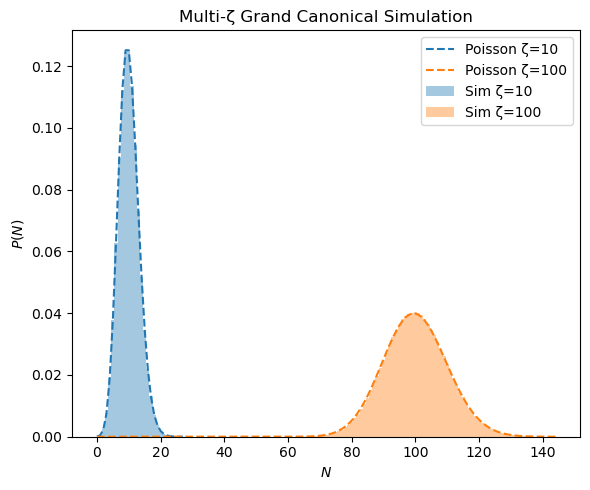

In [3]:
# Run simulations for ζ = 10 and 100 with M = 3
results_10 = grand_canonical_mc(zeta=10, M=3, n_steps=10**6, show_progress=True)
results_100 = grand_canonical_mc(zeta=100, M=3, n_steps=10**6, show_progress=True)

# Store in a dictionary with zeta as labels
results_dict = {
    10: results_10,
    100: results_100
}

# Plot them together
plot_histograms(results_dict, title="Multi-ζ Grand Canonical Simulation")


ζ=1000, M=100: 100%|██████████| 1000000/1000000 [00:20<00:00, 48865.42it/s]


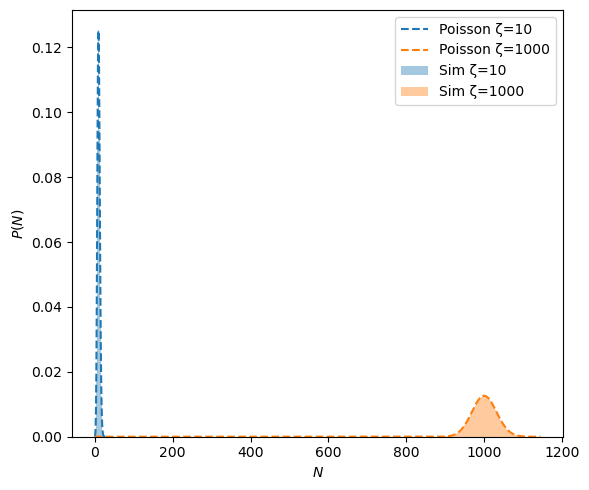

In [5]:
# Run simulations for ζ = 10 with M = 3, ζ = 1000 with M = 100
results_small = grand_canonical_mc(zeta=10, M=3, n_steps=10**6, show_progress=True)
results_big = grand_canonical_mc(zeta=1000, M=100, n_steps=10**6, show_progress=True)

# Store in a dictionary with zeta as labels
results_dict_II = {
    10: results_small,
    1000: results_big
}

# Plot them together
plot_histograms(results_dict_II, title="")


Mean N: 9.980426
Variance: 9.964556858523999


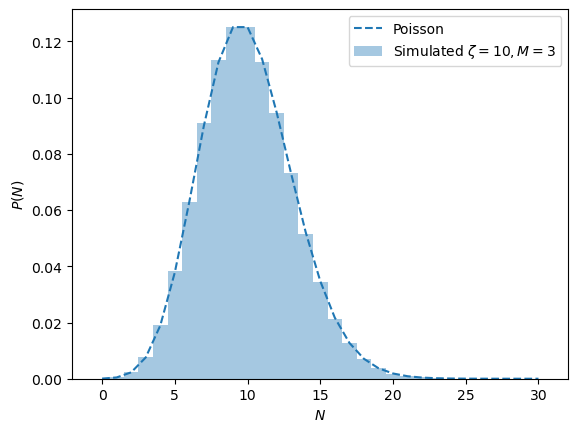

In [6]:
print("Mean N:", results_small['mean'])
print("Variance:", results_small['variance'])

import matplotlib.pyplot as plt
plt.bar(results_small['centers'], results_small['histogram'], width=1, alpha=0.4, label='Simulated $\zeta=10, M=3$')
plt.plot(np.arange(len(results_small['poisson_theory'])), results_small['poisson_theory'], '--', label='Poisson')
plt.xlabel('$N$')
plt.ylabel('$P(N)$')
plt.legend()
plt.show()


Mean N: 999.939255
Variance: 1011.4355790449748


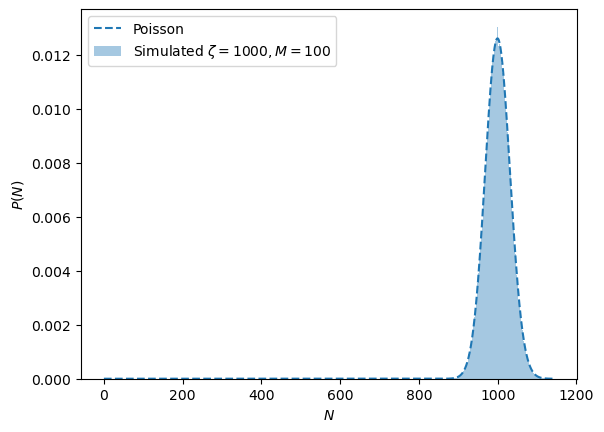

In [7]:
print("Mean N:", results_big['mean'])
print("Variance:", results_big['variance'])

plt.bar(results_big['centers'], results_big['histogram'], width=1, alpha=0.4, label='Simulated $\zeta=1000, M=100$')
plt.plot(np.arange(len(results_big['poisson_theory'])), results_big['poisson_theory'], '--', label='Poisson')
plt.xlabel('$N$')
plt.ylabel('$P(N)$')
plt.legend()
plt.show()


#### e) Autocorrelation analysis of $N_k$ in grand canonical Monte Carlo

GOAL: Analyze how correlated the particle number samples $N_k$ are across Monte Carlo steps by computing the autocorrelation function:

$C(\ell) = \langle N_k N_{k+\ell} \rangle - \langle N \rangle^2$

for $\ell = 0, 1, \dots, 20$, averaged over:
- multiple **offsets** $k$ (to reduce statistical noise)
- multiple **independent runs** with different random seeds

In [8]:
def compute_autocorrelation(N_values, max_lag=20, offset_start=100, offset_step=20):
    """
    Compute autocorrelation function C(ℓ) from time series N_values.
    Returns:
    - lags: array of lag times
    - C: array of autocorrelation values
    """
    N_values = np.asarray(N_values)
    mean_N = np.mean(N_values)
    lags = np.arange(0, max_lag + 1)
    C = np.zeros_like(lags, dtype=float)
    offsets = np.arange(offset_start, len(N_values) - max_lag, offset_step)

    for i, ell in enumerate(lags):
        corr_sum = 0.0
        count = 0
        for k in offsets:
            if k + ell < len(N_values):
                corr_sum += N_values[k] * N_values[k + ell]
                count += 1
        if count > 0:
            C[i] = corr_sum / count - mean_N**2

    return lags, C

def average_autocorrelation(zeta, M, n_steps=10**6, n_seeds=10, max_lag=20):
    """
    Average autocorrelation function C(ℓ) over multiple MC seeds.
    Returns:
    - lags: array of lag values
    - C_mean: average C(ℓ)
    - C_std: std deviation of C(ℓ)
    - all_C: all individual C(ℓ) curves
    """
    all_C = []
    for seed in tqdm(range(n_seeds), desc=f"ζ={zeta}, M={M}"):
        res = grand_canonical_mc(zeta=zeta, M=M, n_steps=n_steps, seed=seed, show_progress=False)
        N_vals = res['N_values']
        lags, C = compute_autocorrelation(N_vals, max_lag=max_lag)
        all_C.append(C)
    all_C = np.array(all_C)
    return lags, np.mean(all_C, axis=0), np.std(all_C, axis=0), all_C

def plot_autocorrelations_average(autocorr_dict, all_C_dict):
    """
    Plot C(ℓ)/C(0) for each (ζ, M) pair:
    - Shaded area = individual runs
    - Error bars = mean ± std over seeds
    """
    plt.figure(figsize=(6, 5))

    for label, (lags, C_mean, C_std) in autocorr_dict.items():
        all_C = all_C_dict[label]
        for curve in all_C:
            plt.plot(lags, curve / curve[0], alpha=0.2, color='gray')
        plt.errorbar(lags, C_mean / C_mean[0], yerr=C_std / C_mean[0],
                     fmt='o-', label=f'{label} (mean)', capsize=3)

    plt.xlabel('$\Delta \ell$')
    plt.ylabel('$C(\ell)/C(0)$')
    plt.legend()
    plt.tight_layout()
    plt.show()


ζ=1000, M=100: 100%|██████████| 10/10 [03:00<00:00, 18.00s/it]


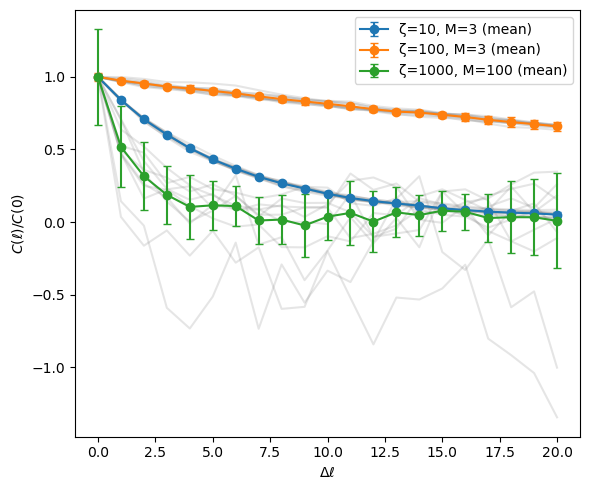

In [13]:
autocorr_data_dict = {}
all_C_dict = {}

#  cases
param_list = [
    (10, 3),
    (100, 3),
    (1000, 100)
]

# Loop over cases
for zeta, M in param_list:
    label = f'ζ={zeta}, M={M}'
    lags, C_mean, C_std, all_C = average_autocorrelation(zeta, M, n_seeds=10) #change to 10
    autocorr_data_dict[label] = (lags, C_mean, C_std)
    all_C_dict[label] = all_C

# Plot all autocorrelation results
plot_autocorrelations_average(autocorr_data_dict, all_C_dict)

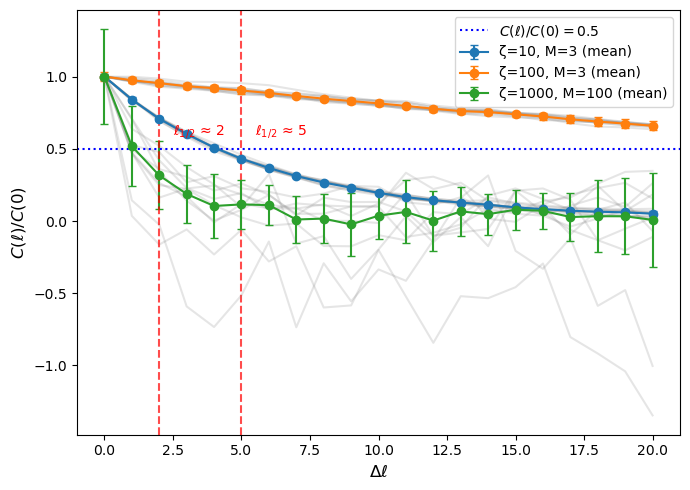

In [14]:
def plot_autocorrelations_average_with_decay(autocorr_dict, all_C_dict):
    """
    Plot C(ℓ)/C(0) for each (ζ, M) pair:
    - Gray lines: individual simulation runs
    - Colored error bars: mean ± std over seeds
    - Horizontal dashed line at C(ℓ)/C(0) = 0.5
    - Vertical dashed line at estimated ℓ₁/₂ for each (ζ, M)
    """
    plt.figure(figsize=(7, 5))

    for label, (lags, C_mean, C_std) in autocorr_dict.items():
        all_C = all_C_dict[label]
        
        # Plot individual runs
        for curve in all_C:
            plt.plot(lags, curve / curve[0], alpha=0.2, color='gray')
        
        # Mean + error bars
        norm_mean = C_mean / C_mean[0]
        plt.errorbar(lags, norm_mean, yerr=C_std / C_mean[0],
                     fmt='o-', label=f'{label} (mean)', capsize=3)
        
        # Compute and mark ℓ₁/₂
        ell_half = next((ell for ell, val in zip(lags, norm_mean) if val <= 0.5), None)
        if ell_half is not None:
            plt.axvline(ell_half, linestyle='--', color='red', alpha=0.7)
            plt.text(ell_half + 0.5, 0.6, f'$\\ell_{{1/2}}$ ≈ {ell_half}', color='red')

    # Reference line at 0.5
    plt.axhline(0.5, linestyle=':', color='blue', label='$C(\\ell)/C(0) = 0.5$')
    
    plt.xlabel('$\Delta \ell$', fontsize=12)
    plt.ylabel('$C(\ell)/C(0)$', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_autocorrelations_average_with_decay(autocorr_data_dict, all_C_dict)


In [15]:
print("Estimated decay lags ℓ₁/₂:")

for label, (lags, C_mean, _) in autocorr_data_dict.items():
    norm = C_mean / C_mean[0]
    ell_half = next((ell for ell, val in zip(lags, norm) if val <= 0.5), None) #return the first lag where the norm autocorrelation is less or equal to 1/2
    print(f"{label}: ℓ₁/₂ ≈ {ell_half}")

Estimated decay lags ℓ₁/₂:
ζ=10, M=3: ℓ₁/₂ ≈ 5
ζ=100, M=3: ℓ₁/₂ ≈ None
ζ=1000, M=100: ℓ₁/₂ ≈ 2


####  Interpretation:
- Small $\ell_{1/2}$ ⟶ fast decorrelation ⟶ efficient sampling
- Large $\ell_{1/2}$ or no decay ⟶ strong correlations ⟶ poor mixing
- Example:
  - `ζ=10, M=3`: $\ell_{1/2} \approx 5$
  - `ζ=1000, M=100`: $\ell_{1/2} \approx 2$ (fast!)
  - `ζ=100, M=3`: $\ell_{1/2}$ not reached (indicates slow decorrelation)


#### f*): Poisson sampling via multiplicative method

**Knuth's algorithm** for Poisson sampling:

def knuth_poisson(zeta, rng):
    L = np.exp(-zeta)
    p = 1.0
    k = 0
    while p > L:
        p *= rng.random()
        k += 1
    return k - 1

- The Poisson distribution is defined as:
  
  $P(N = k) = \frac{\zeta^k e^{-\zeta}}{k!}$
  
- The algorithm is based on a probabilistic derivation using the fact that inter-arrival times in a Poisson process are exponentially distributed
- The loop multiplies uniform random variables $u_i$ until the product drops below $e^{-\zeta}$, effectively counting how many events occur in a unit time interval of a Poisson process with rate $\zeta$


- The expected number of iterations (i.e., uniform random numbers generated) is roughly:
  
  $\mathbb{E}[k] \approx \zeta$

- So, for:
  - **$\zeta = 10$**, it takes about 10 random numbers per sample
  - **$\zeta = 1000$**, it takes about 1000 random numbers per sample — **computationally expensive**

- The MC method is more efficient for **large $\zeta$**, since you can collect many moderately correlated samples at much lower cost.
- Knuth's algorithm is ideal for generating **independent samples**, but becomes **prohibitively expensive** at large $\zeta$

In [19]:
# --- Knuth's Poisson sampler ---
def knuth_poisson(zeta, rng):
    L = np.exp(-zeta)
    p = 1.0
    k = 0
    rng_calls = 0
    while p > L:
        p *= rng.random()
        k += 1
        rng_calls += 1
    return k - 1, rng_calls

# --- Autocorrelation helper ---
def compute_ell_half(N_vals, max_lag=20, offset=100):
    N_vals = N_vals[offset:]
    mean = np.mean(N_vals)
    C0 = np.mean(N_vals**2) - mean**2
    for ell in range(1, max_lag + 1):
        C = np.mean(N_vals[:-ell] * N_vals[ell:]) - mean**2
        if C / C0 <= 0.5:
            return ell
    return None

# MC simulation
def grand_canonical_mc(zeta=10, M=3, n_samples=10000, seed=None, show_progress=True):
    rng = np.random.default_rng(seed)
    N = 0
    N_values = []
    step = 0
    iterator = tqdm(total=n_samples, desc=f"ζ={zeta}, M={M}", disable=not show_progress)
    while len(N_values) < n_samples:
        m = rng.integers(1, M + 1)
        if rng.random() < 0.5:
            log_acc = m * np.log(zeta) - np.sum(np.log(np.arange(N + 1, N + m + 1)))
            acc = min(1, np.exp(log_acc)) if np.isfinite(log_acc) else 0
            if rng.random() < acc:
                N += m
        else:
            if N >= m:
                log_acc = np.sum(np.log(np.arange(N - m + 1, N + 1))) - m * np.log(zeta)
                acc = min(1, np.exp(log_acc)) if np.isfinite(log_acc) else 0
                if rng.random() < acc:
                    N -= m
        N_values.append(N)
        step += 1
        iterator.update(1)
    return {'N_values': np.array(N_values), 'steps': step}

# Comparison function
def compare_efficiency_fixed_samples(zeta=1000, M=100, n_samples=10000, burn_in=100):
    rng = np.random.default_rng(42)

    # Knuth
    knuth_rng_calls = []
    for _ in tqdm(range(n_samples), desc="Knuth Sampling"):
        _, count = knuth_poisson(zeta, rng)
        knuth_rng_calls.append(count)
    total_rng_knuth = np.sum(knuth_rng_calls)
    avg_knuth = np.mean(knuth_rng_calls)

    # MC
    mc_result = grand_canonical_mc(zeta=zeta, M=M, n_samples=n_samples, seed=0, show_progress=True)
    N_vals = mc_result['N_values']
    total_steps = mc_result['steps']
    ell_half = compute_ell_half(N_vals)
    effective_samples = (len(N_vals) - burn_in) // ell_half if ell_half else 1
    rngs_per_eff_sample = (total_steps - burn_in) / effective_samples if effective_samples else np.inf

    # Output summary
    print(f"\n Efficiency Comparison (Same # of samples = {n_samples})")
    print("—" * 50)
    print("Knuth:")
    print(f"   Avg RNGs/sample:        {avg_knuth:.1f}")
    print(f"   Total RNG calls:        {total_rng_knuth}")
    print()
    print("Metropolis MC:")
    print(f"   MC steps taken:         {total_steps}")
    print(f"   ℓ₁/₂ (decay lag):        {ell_half}")
    print(f"   Effective samples:      {effective_samples}")
    print(f"   RNGs per eff. sample:   {rngs_per_eff_sample:.1f}")
    print(f"   Total RNG calls:        {total_steps}")

# Run the updated comparison
compare_efficiency_fixed_samples(zeta=1000, M=100, n_samples=10000)


Knuth Sampling:   0%|          | 0/10000 [00:00<?, ?it/s]

ζ=1000, M=100: 100%|██████████| 10000/10000 [00:00<00:00, 41002.92it/s]


 Efficiency Comparison (Same # of samples = 10000)
——————————————————————————————————————————————————
Knuth:
   Avg RNGs/sample:        746.4
   Total RNG calls:        7463870

Metropolis MC:
   MC steps taken:         10000
   ℓ₁/₂ (decay lag):        2
   Effective samples:      4950
   RNGs per eff. sample:   2.0
   Total RNG calls:        10000
